In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression



2024-03-19 01:36:35.102731: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 01:36:35.134251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 01:36:35.626068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Dataset
Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [10]:
dataset_cols=['bike_count','hour','temp','humidity','wind','visibility','dew_pt_temp','radiation','rain','snow','functional']
df=pd.read_csv('SeoulBikeData.csv').drop(['Date','Holiday','Seasons'],axis=1)

In [15]:
df.columns=dataset_cols
df['functional']=(df['functional']=='Yes').astype(int)
df=df[df['hour'] == 12]
df=df.drop(['hour'], axis =1)

In [16]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


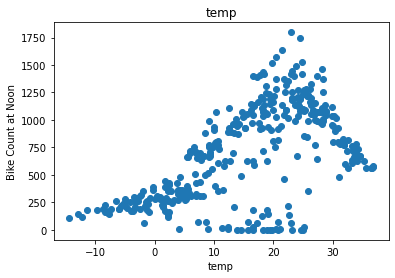

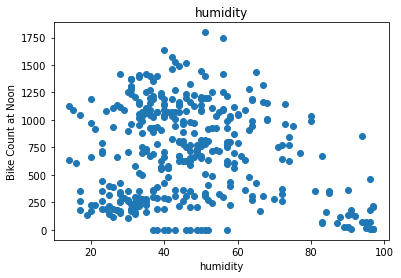

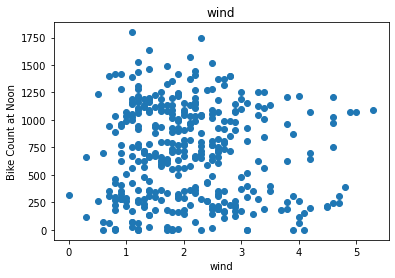

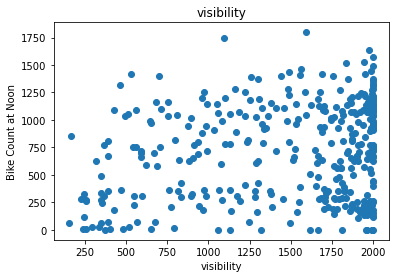

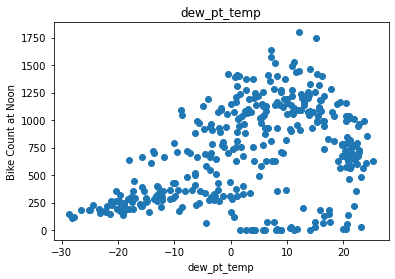

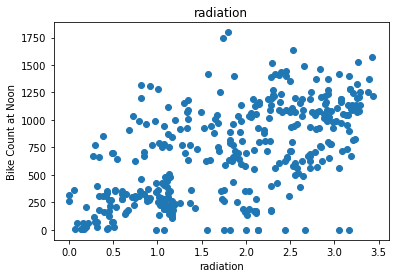

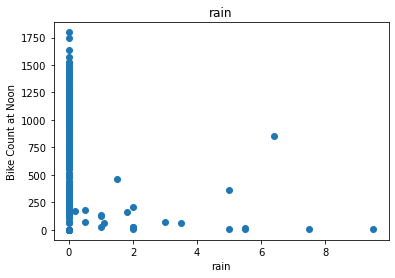

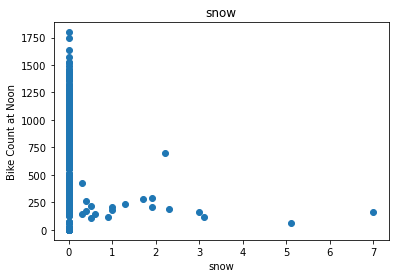

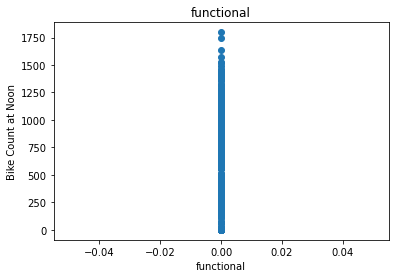

In [17]:
for label in df.columns[1:]:
    plt.scatter(df[label],df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at Noon')
    plt.xlabel(label)
    plt.show()

In [18]:
df=df.drop(['wind','visibility','functional'],axis=1)

In [19]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/valid/test dataset

In [31]:
train, val, test= np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

In [32]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe=copy.deepcopy(dataframe)
    if  x_labels is None:
        X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels)==1:
            X=dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X=dataframe[x_labels].values
            
    y=dataframe[y_label].values.reshape(-1,1)
    data=np.hstack((X,y))
    
    return data, X, y

In [23]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [25]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [26]:
print(temp_reg.coef_, temp_reg.intercept_)

[[22.23473528]] [361.37393183]


In [27]:
temp_reg.score(X_test_temp, y_test_temp)

0.276707455301601

2024-03-19 02:25:42.828662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 02:25:42.829560: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


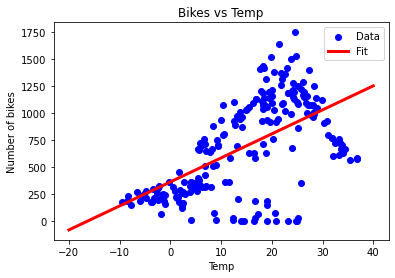

In [28]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x=tf.linspace(-20, 40,100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

# Multiple linear Regression

In [75]:
# train, val, test= np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, 'bike_count', x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bike_count', x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', x_labels=df.columns[1:])

In [34]:
all_reg=LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [35]:
all_reg.score(X_test_all, y_test_all)

0.3922919198925827

In [128]:
y_pred_lr=all_reg.predict(X_test_all)

# Regression with Neural Net

In [41]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
temp_normalizer=  tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/home/anamaria/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [44]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [46]:
history= temp_nn_model.fit(X_train_temp.reshape(-1), y_train_temp, verbose=0, epochs=1000, validation_data=(X_val_temp, y_val_temp))

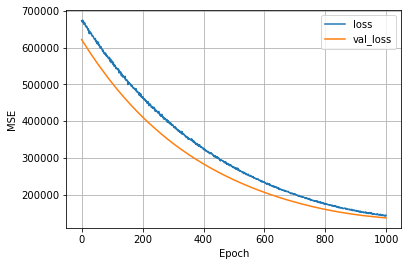

In [47]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


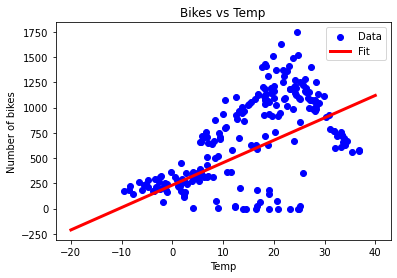

In [48]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x=tf.linspace(-20, 40,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

# Neural Net


In [57]:
temp_normalizer=  tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model= tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [58]:
history=nn_model.fit(X_train_temp, y_train_temp, validation_data=(X_val_temp, y_val_temp), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 675519.5625 - val_loss: 622843.0000
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 726070.7500 - val_loss: 622736.3750
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 635139.8750 - val_loss: 622601.6875
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 685712.1875 - val_loss: 622449.3125
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 704581.0000 - val_loss: 622286.7500
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 657852.3750 - val_loss: 622106.2500
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 732708.8125 - val_loss: 621900.9375
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 660282.3125 - val_loss: 621673.5000
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 699525.6250 - val_loss: 621409.4375
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 646418.3125 - val_loss: 621105.5625
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 725466.937

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 406125.9688 - val_loss: 340050.1875
Epoch 66/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 374658.2500 - val_loss: 329672.0938
Epoch 67/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 386397.2812 - val_loss: 319339.8438
Epoch 68/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 344660.6562 - val_loss: 309213.0938
Epoch 69/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 337978.8438 - val_loss: 299032.5312
Epoch 70/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 336531.3438 - val_loss: 289029.6875
Epoch 71/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 312489.1875 - val_loss: 279303.4688
Epoch 72/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 305442.4375 - val_loss: 269656.9688
Epoch 73/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 325315.2812 - val_loss: 260171.1094
Epoch 74/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 313886.9062 - val_loss: 251032.5156
Epoch 75/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 284860.1875 - v

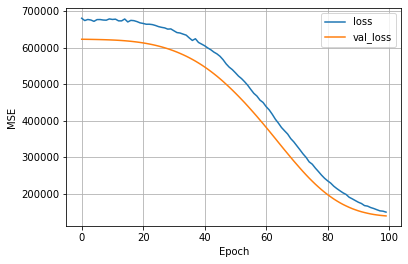

In [59]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


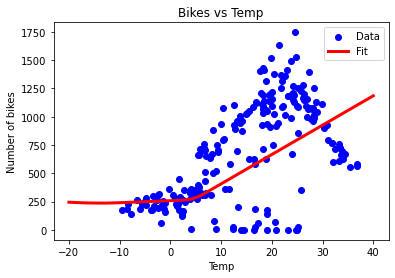

In [60]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x=tf.linspace(-20, 40,100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

In [123]:
all_normalizer=tf.keras.layers.Normalization(input_shape=(6,), axis= -1 )
all_normalizer.adapt(X_train_all)

In [130]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

TypeError: Trainer.compile() got an unexpected keyword argument 'experimental_compile'

In [125]:
history=nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 718080.1875 - val_loss: 511874.9688
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 691473.0000 - val_loss: 511655.3750
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 765559.0000 - val_loss: 511407.9062
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 705327.8750 - val_loss: 511117.2500
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 704065.8125 - val_loss: 510766.2188
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 652389.6250 - val_loss: 510345.0312
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 733766.5625 - val_loss: 509833.1250
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 713139.8125 - val_loss: 509226.5938
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 657086.5000 - val_loss: 508498.7812
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 768731.2500 - val_loss: 507613.6250
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 684290.250

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 180428.9688 - val_loss: 121572.3828
Epoch 66/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 160063.6250 - val_loss: 120471.3203
Epoch 67/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 157298.0781 - val_loss: 119549.7188
Epoch 68/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154633.6250 - val_loss: 118739.5938
Epoch 69/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 159420.0156 - val_loss: 117965.0859
Epoch 70/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143038.4844 - val_loss: 117204.3750
Epoch 71/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 153112.2344 - val_loss: 116539.8125
Epoch 72/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 147234.4219 - val_loss: 115880.6875
Epoch 73/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 129437.1094 - val_loss: 115364.6250
Epoch 74/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135206.2500 - val_loss: 114744.7734
Epoch 75/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 150851.8906 - v

In [112]:
nn_model.summary()


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_13                │ (None, 6)              │            13 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,954 (15.45 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 13 (56.00 B)

 Optimizer params: 2,628 (10.27 KB)

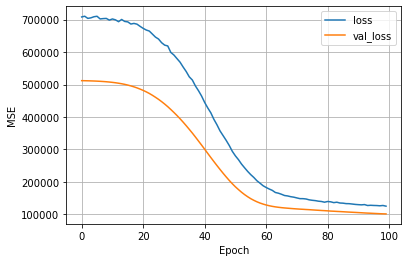

In [126]:
plot_loss(history)

### calculate the MSE for both linear reg and nn


In [129]:
y_pred_lr=all_reg.predict(X_test_all)
y_pred_nn=nn_model.predict(X_test_all)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x79a7712b4790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [131]:
def MSE (y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [133]:
MSE(y_pred_lr, y_test_all)

102751.77300377337

In [134]:
MSE(y_pred_nn, y_test_all)

130118.55610065203

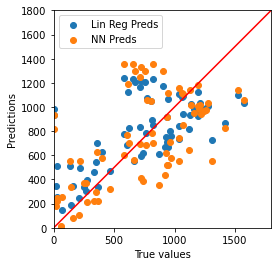

In [136]:
ax=plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label='Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label='NN Preds')
plt.xlabel('True values')
plt.ylabel('Predictions')
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_=plt.plot(lims, lims, c='red')